# Notebook 1: scikit-learn at scale

The goal of this notebook is to give you a sense of some of the computational limitations one may encounter when training or applying ML models on large scale datasets, as well as to explore some of scikit-learn's tools to improve runtime.

__If you are taking this class for credit, you will need to turn in your completed notebook on Campus.__

This notebook was prepared on Jupyter Lab 3.2.9 by [Chloé Azencott](http://cazencott.info), using Python 3.9.7 with `joblib 1.1.0`, `matplotlib 3.5.1`, `numpy 1.21.2`, `scipy 1.7.3`, and `sklearn 1.0.2`.

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

## 1. Data setup

We will work with the [Forest Covertypes](https://scikit-learn.org/stable/datasets/real_world.html#forest-covertypes) data set.

In [3]:
from sklearn import datasets

In [4]:
forest_dataset = datasets.fetch_covtype()

In [5]:
X = forest_dataset['data']
y = forest_dataset['target']

In [7]:
X.shape, y.shape

((581012, 54), (581012,))

In [8]:
n_samples = X.shape[0]
n_features = X.shape[1]

#### Creating subsets of varying sample sizes

The data set contains about 500k samples. Let us create subsets of the data, to explore how sample sizes affects complexity. We'll use the `train_test_split` function of sklearn to that effect.

In [9]:
from sklearn import model_selection

In [11]:
subsample_sizes = [500, 1000, 5000, 10000, 50000, 100000, 200000]
subsample_data = {} # key: number of subsamples, value:(X_subsample, y_subsample)
for ssize in subsample_sizes:
    X_tr, X_te, y_tr, y_te = model_selection.train_test_split(X, y, shuffle=True, random_state=57, stratify=y, train_size=ssize)
    subsample_data[ssize] = (X_tr, y_tr)
del X_te, y_te

# Adding the full data set to the dictionary
subsample_data[n_samples] = (X, y)
subsample_sizes.append(n_samples)

subsample_sizes = np.array(subsample_sizes)

__IMPORTANT NOTE:__ If later in the notebook cells are taking too long to run, reduce the values in `subsample_sizes`. For example, consider 
```python
subsample_sizes = [500, 1000, 5000, 10000, 50000, 75000, 100000]
```
or
```python
subsample_sizes = [500, 1000, 5000, 10000, 25000, 50000]
```

#### Size of each data set in memory

In [12]:
for ssize in subsample_sizes:
    X_current, y_current = subsample_data[ssize]
    print(f"Dataset with {ssize} samples takes {(X_current.size * X_current.itemsize):.2e} bytes of memory")

Dataset with 500 samples takes 2.16e+05 bytes of memory
Dataset with 1000 samples takes 4.32e+05 bytes of memory
Dataset with 5000 samples takes 2.16e+06 bytes of memory
Dataset with 10000 samples takes 4.32e+06 bytes of memory
Dataset with 50000 samples takes 2.16e+07 bytes of memory
Dataset with 100000 samples takes 4.32e+07 bytes of memory
Dataset with 200000 samples takes 8.64e+07 bytes of memory
Dataset with 581012 samples takes 2.51e+08 bytes of memory


Our datasets take from 216 KB to 251 MB of space in memory.

## 2. Decision trees

### 1.2 Training a decision tree: complexity w.r.t. the number of samples

The computational complexity for building a decision tree with CART is about $\mathcal{O}(p n \log n)$ if the features are binary and $\mathcal{O}(p n^2)$. This is in the case where the tree that is built is balanced (about the same number of training samples go to each branch at each node). 

In the worse case scenario (a single training sample goes to one of the two branches at each node), this complexity becomes $\mathcal{O}(p n^2)$ if the features are binary and $\mathcal{O}(p n^3)$ if they are continuous.

For details, you can consult [this document](http://cazencott.info/dotclear/public/lectures/Decision_Tree_Complexity.pdf).

##### __Question 1__
How many of the features are binary? Do you expect the runtime to be loglinear or quadratic in the number of samples?

In [15]:
import pandas as pd

__Answer:__

In [39]:
X_df = pd.DataFrame(X)
nb_binary_features = 0
for i in range(n_features):
    if len(X_df.iloc[:,i].unique())==2:
        nb_binary_features += 1
        continue
        
print(f"There are {nb_binary_features} binary features in the dataset.")

There are 44 binary features in the dataset.


We expect the runtime to be O(pnlog(n)) as most features are binary, so loglinear?

#### Empirical runtime as a function of the number of samples

We will now evaluate this runtime empirically, on our subsets of the data.

In [40]:
import time # to compute runtimes

In [41]:
from sklearn import tree 

In [42]:
runtimes = {} # key: number of subsamples, value: time to train a decision tree with default parameter
for ssize in subsample_sizes:
    X_current, y_current = subsample_data[ssize]
    dt_classifier = tree.DecisionTreeClassifier() # default parameters
    
    start_time = time.time()
    dt_classifier.fit(X_current, y_current)
    runtimes[ssize] = time.time() - start_time

Text(0.5, 1.0, 'Time to train a decision tree')

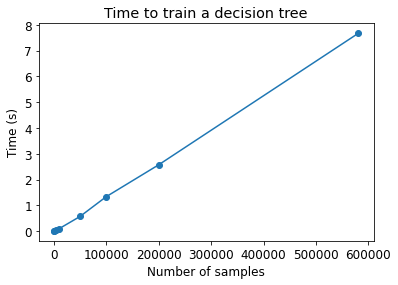

In [43]:
plt.plot(subsample_sizes, [runtimes[ssize] for ssize in subsample_sizes], 'o-')
plt.xlabel("Number of samples")
plt.ylabel("Time (s)")
plt.title("Time to train a decision tree")

To better visualize the first data points, we can switch to a log scale on the x-axis.

Text(0.5, 1.0, 'Time to train a decision tree')

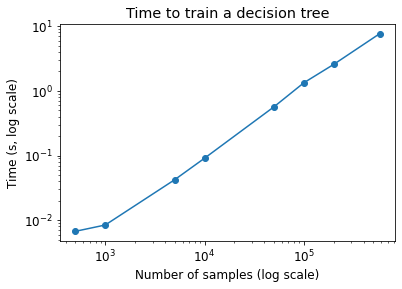

In [44]:
plt.loglog(subsample_sizes, [runtimes[ssize] for ssize in subsample_sizes], 'o-')
plt.xlabel("Number of samples (log scale)")
plt.ylabel("Time (s, log scale)")
plt.title("Time to train a decision tree")

#### Fitting a complexity model

It is hard to conclude on the computational complexity of the algorithm in practice from the above plot. In this section, we will check what type of computational complexity function fits our observations best. For this purpose, we'll use the [curve fitting algorithm of `scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

In [45]:
from scipy import optimize

Let us define now 3 types of computational complexities we are willing to consider:

In [46]:
def f_linear(n, a):
    """Linear complexity"""
    return (a * n)

In [47]:
def f_loglinear(n, a):
    """Loglinear complexity"""
    return (a * n * np.log2(n))

In [48]:
def f_quadratic(n, a):
    """Quadratic complexity"""
    return (a * n**2)

Now we use `curve_fit` to fit the data to the models. What is happening under the hood is an ordinary least squares approach (minimization of the sum of squares).

In [49]:
p_opt_linear, p_cov = optimize.curve_fit(f_linear, subsample_sizes, [runtimes[ssize] for ssize in subsample_sizes])
p_opt_loglinear, p_cov = optimize.curve_fit(f_loglinear, subsample_sizes, [runtimes[ssize] for ssize in subsample_sizes])
p_opt_quadratic, p_cov = optimize.curve_fit(f_quadratic, subsample_sizes, [runtimes[ssize] for ssize in subsample_sizes])

And now we plot the learned models as well as the observed runtimes.

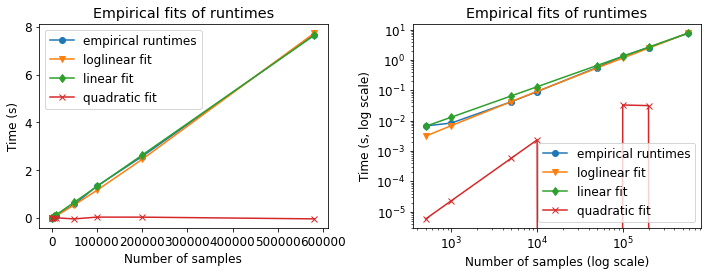

In [50]:
fig = plt.figure(figsize=(10, 4))

# Linear axes
plt.subplot(1, 2, 1) # grid 1x2 subplots, subplot 1
plt.plot(subsample_sizes, [runtimes[ssize] for ssize in subsample_sizes], 'o-', label="empirical runtimes")
plt.plot(subsample_sizes, f_loglinear(subsample_sizes, p_opt_loglinear[0]), 'v-', label="loglinear fit")
plt.plot(subsample_sizes, f_linear(subsample_sizes, p_opt_linear[0]), 'd-', label="linear fit")
plt.plot(subsample_sizes, f_quadratic(subsample_sizes, p_opt_quadratic[0]), 'x-', label="quadratic fit")

plt.xlabel("Number of samples")
plt.ylabel("Time (s)")
plt.title("Empirical fits of runtimes")
plt.legend()

# Log axes
plt.subplot(1, 2, 2) # grid 1x2 subplots, subplot 2
plt.loglog(subsample_sizes, [runtimes[ssize] for ssize in subsample_sizes], 'o-', label="empirical runtimes")
plt.loglog(subsample_sizes, f_loglinear(subsample_sizes, p_opt_loglinear[0]), 'v-', label="loglinear fit")
plt.loglog(subsample_sizes, f_linear(subsample_sizes, p_opt_linear[0]), 'd-', label="linear fit")
plt.loglog(subsample_sizes, f_quadratic(subsample_sizes, p_opt_quadratic[0]), 'x-', label="quadratic fit")

plt.xlabel("Number of samples (log scale)")
plt.ylabel("Time (s, log scale)")
plt.title("Empirical fits of runtimes")
plt.legend()

# Adjust spacing between plots
fig.tight_layout()

##### __Question 2__ 
Is the relationship between the time required to train a decision tree and the number of samples linear? loglinear? quadratic? Does this match your expectations?

__Answer:__ According to these graphs, we can see that the relationship between the time required to train a decision tree and the number of samples is loglinear. Even though our first point follows a linear fit, it might be due to the small number of samples it has. For larger number of samples, it follows a loglinear fit. It matches our expectations : we have 54 features and 44 of them are binary. So we expected this type of relationship.

#### Size of a tree in memory

We will now use `joblib` to save estimators to disk and see how much space the models take to store.

You can read more about `joblib` [here](https://joblib.readthedocs.io/en/latest/), and about *model persistence* (ie. how to save a trained model) in scikit-learn [here](https://scikit-learn.org/stable/modules/model_persistence.html).

If `joblib` isn't installed on your system, you should be able to install it with `conda install joblib`.

In [51]:
import joblib
import os

In [52]:
tree_joblib_size = {} # key: number of subsamples, value: size of file on disk
for ssize in subsample_sizes:
    X_current, y_current = subsample_data[ssize]
    dt_classifier = tree.DecisionTreeClassifier() # default parameters
    dt_classifier.fit(X_current, y_current)
    file_name = "dt_classifier_%d.joblib" % ssize
    joblib.dump(dt_classifier, file_name)
    print("Tree size: %.2e bytes" % os.path.getsize(file_name))
    tree_joblib_size[ssize] = os.path.getsize(file_name)

Tree size: 2.71e+04 bytes
Tree size: 4.93e+04 bytes
Tree size: 2.01e+05 bytes
Tree size: 3.69e+05 bytes
Tree size: 1.31e+06 bytes
Tree size: 2.11e+06 bytes
Tree size: 3.25e+06 bytes
Tree size: 6.18e+06 bytes


##### __Question 3__ 
Complete the code below to plot, as a function of the number of samples, the size in bytes of 1) the data set and 2) the model file.

In [62]:
list(tree_joblib_size.items())

[(500, 27076),
 (1000, 49255),
 (5000, 200679),
 (10000, 368903),
 (50000, 1311271),
 (100000, 2110055),
 (200000, 3250663),
 (581012, 6176327)]

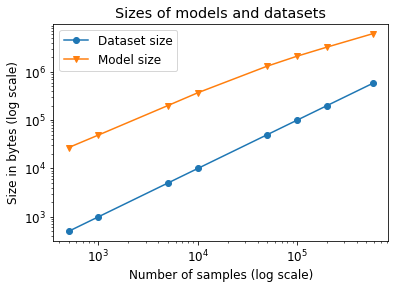

In [66]:
plt.loglog(subsample_sizes, list(tree_joblib_size.keys()), #NOT SURE? I WANT TO HAVE THE DATASET SIZES
           'o-', label='Dataset size')
plt.loglog(subsample_sizes, list(tree_joblib_size.values()), 
           'v-', label='Model size')

plt.xlabel("Number of samples (log scale)")
plt.ylabel("Size in bytes (log scale)")
plt.title("Sizes of models and datasets")
plt.legend()

You can check that the sizes you have computed match those given by your operating system.

For example, here's a screenshot of my file manager (for the folder in which I am running the notebook):

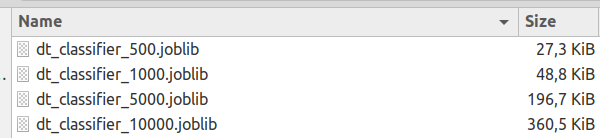

Note that my file system gives file sizes in KiB and MiB (1 KiB = $2^{10}$ B = 1024 B) and not KB and MB (1 KB = $10^3$ B = 1000 B). 

__Comment:__

You can now remove the joblib files with the following command:

In [67]:
for ssize in subsample_sizes:
    file_name = "dt_classifier_%d.joblib" % ssize
    os.remove(file_name)

#### Limiting the depth of the tree

##### __Question 4__ 
Using the `max_depth` parameter of `DecisionTreeClassifier` to limit the depth of the learned decision tree, evaluate again:
* the runtime, as a function of the number of samples, of training a decision tree of maximum depth 4 
* the space taken in memory by such a model, as a function of the number of samples.

Compare with the previous section.

In [ ]:
### TODO

__Comment:__

#### Impact of limiting the depth of the tree on tree performance.

##### __Question 5__ 
Using [`sklearn.model_selection.cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html?highlight=cross_val_score#sklearn.model_selection.cross_val_score), complete the code below to compute and compare the 5-fold cross-validated [balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score) of all these decision trees (with/without limiting depth, for all sample sizes). 

In [ ]:
from sklearn import model_selection

In [ ]:
cv_scores_default = {} # key: number of subsamples, value: 5-fold cv balanced accuracy
cv_scores_depth4 = {} # key: number of subsamples, value: 5-fold cv balanced accuracy

for ssize in subsample_sizes:
    X_current, y_current = subsample_data[ssize]
    dt_classifier = tree.DecisionTreeClassifier() # default parameters
    cv_scores_default[ssize] = # TO COMPLETE    
    
    dt_classifier = tree.DecisionTreeClassifier(max_depth=4) # default parameters
    cv_scores_depth4[ssize] = # TO COMPLETE

In [ ]:
plt.errorbar(subsample_sizes, [np.mean(cv_scores_default[ssize]) for ssize in subsample_sizes], 
             yerr=[np.std(cv_scores_default[ssize]) for ssize in subsample_sizes], label='Default')
plt.errorbar(subsample_sizes, [np.mean(cv_scores_depth4[ssize]) for ssize in subsample_sizes],
             yerr=[np.std(cv_scores_depth4[ssize]) for ssize in subsample_sizes], label='Max depth = 4')

plt.xlabel("Number of samples (log scale)")
plt.ylabel("Balanced accuracy")
plt.title("Cross-validated performance of various decision trees")

plt.xscale("log")

plt.legend()

__Comment:__

##### __Question 6__ 
* How does limiting the depth of the tree affect performance? 
* Was this expected? 
* Comment this result knowing that our ultimate goal is to train random forests.

In [ ]:
### TODO

__Comment:__

### 1.3 Computational complexity of a decision tree (with respect to the number of features)

Here we'll work with the data set that has 10,000 samples (to avoid longer runtimes on the full data set) and change the number of features. If 10,000 samples takes too long to process on your data set, use a smaller dataset.

#### Creating subsets of varying numbers of features

Here we will merely add random binary features to the data. They will not be useful, but the algorithm will still have to explore them to know that.

In [ ]:
n_subsamples = int(1e4)
X_current, y_current = subsample_data[n_subsamples]

Let us now define a list of feature numbers.

In [ ]:
feature_numbers = [n_features, 100, 500, 1000, 1500] # You can change the values here 
feature_numbers = np.array(feature_numbers)

Now we create the copies of the dataset "augmented" with bogus binary features.

In [ ]:
augmented_data = {} #key: number of features, value: X_augmented
augmented_data[n_features] = X_current
for fnum in feature_numbers[1:]:
    # Create an array of random binary features
    X_aug = np.random.randint(2, size=(n_subsamples, fnum))
    # Fill the first 54 columns with the true data
    X_aug[:, :n_features] = X_current        
    augmented_data[fnum] = X_aug

#### Size of each data set in memory

##### __Question 7__ 
Compute the sizes of each data set in bytes.

In [ ]:
### TODO

__Comment:__

#### Tree complexity as a function of the number of features

##### __Question 8__ 
Compute and plot
* the runtime, as a function of the number of features, of training a decision tree with no limit on the depth
* the space taken in memory by the model, as a function of the number of features
* the runtime, as a function of the number of features, of training a decision tree of maximum depth 4 
* the space taken in memory by the model, as a function of the number of features.

In [ ]:
### TODO

__Comment:__

##### __Question 9__ 
* What is the relationship (logistic, linear, loglinear, quadratic, etc.) between the number of features and the runtime? 
* Does it match your expectations?

In [ ]:
### TODO

__Comment:__

## 3. Random forests

### 3.1 Complexity of training a random forest

Training a random forest is done by constructing `n_trees` decision trees, each trained on a data set constructing by
* subsampling the observations; typically, this is done with bootstrap sampling, where $n$ observations are sampled *with replacement* (i.e. some will be sampled several times and others never, resulting in approximately selecting 2/3 of the samples);
* subsampling the features; typically, this is done by randomly sampling $p$ features.

##### __Question 10__ 
* What do you expect the time complexity of training __one__ of the decision trees of a random forest?
* How much time do you expect training a random forest of 100 trees on the full data set will take if you're not limiting tree depth? If you're limiting tree depth?
* How much space do you expect that random forest model to take in memory if you're not limiting tree depth? If you're limiting tree depth?

__Answer:__

##### __Question 11__ 
* Set up an experiment to verify this complexity using the [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) class. Use at least 100 trees in your random forest. 
Make sure to use the training times you have observed before to decide on the numbers of samples to use. Do not limit tree depth. Do the numbers match your expectations?
* How much space do your trained random forests take in memory? Does this match your expectations?

In [ ]:
from sklearn import ensemble

In [ ]:
### TODO

__Comment:__

### 3.2 Prediction latency

Doing predictions in bulk (many samples at the same time) rather than one sample at a time is more efficient. This is due to several reasons, that include CPU caching and [branch prediction](https://en.wikipedia.org/wiki/Branch_predictor). For many models, this can also be due to the efficiency of linear algebra libraries.

Here is an example for one random forest, trained on 5,000 samples, with 100 trees:

In [ ]:
ssize = 5000
X_current, y_current = subsample_data[ssize]
rf_classifier = ensemble.RandomForestClassifier(max_depth=4)

# Training
rf_classifier.fit(X_current, y_current)

# Predicting on 1 sample
start_time = time.time()
rf_classifier.predict(X_current[:1, :])
mytime = time.time() - start_time
print("Time to predict on one sample: %.3f s" % (mytime))
print("Time to predict on one sample (x %d): %.2f s" % (ssize, (mytime * ssize)))

# Predicting on 5000 samples
start_time = time.time()
rf_classifier.predict(X_current)
print("Time to predict on %d samples: %.2f s" % (ssize, (time.time() - start_time)))

##### __Question 12__ 
For several values of n, compare the time it takes to predict on n samples to n times the time it takes to predict on 1 sample. Produce a plot.

In [ ]:
### TODO

__Comment:__

### 3.3 Parallelization

Random forests are embarassingly parallel, meaning that very little effort is required to parallelize them: all of the decision trees that compose it can be trained and applied independently from each other. If your machine has several computing cores, each of them can be used to compute some trees in parallel. `scikit-learn` facilitates this with the `n_jobs` parameter of the `RandomForestClassifier` class.

##### __Question 13__ 
* Compare the runtime of training a random forest using a single core (`n_jobs=None`, default), using two cores (`n_jobs=2`), and using as many cores as possible (`n_jobs=-1`). You are free to choose wether you're limiting depth or not, how many samples you use, and so on.
* Do the results match your expectations?

In [ ]:
### TODO

__Comment:__

## 4. (Optional) Incremental PCA

Another technique to reduce computation overheads is `incremental learning`, or `mini-batch learning`, or `online learning`. The idea here is to process only a small number of samples at once (one such set of samples is called a batch). This is typically how neural networks are trained, with gradient updates computed sample per sample or mini-batch per mini-batch.
 
The technique can also be applied to other examples, such as Principal Component Analysis. The principle is described in [Weng et al. (2003), *Candid Covariance-Free IncrementalPrincipal Component Analysis*, TPAMI](http://www.cse.msu.edu/~weng/research/CCIPCApami.pdf). Here we will focus on observing its effects on efficiency.

Note that there's a variant of random forests, called Mondrian forests, that allows for online learning, but it is not yet mainstream and it is not implemented in scikit-learn. See [Lakshminarayanan et al. (20140, *Mondrian Forests: Efficient Online Random Forests*, NeurIPS](https://papers.nips.cc/paper/2014/hash/d1dc3a8270a6f9394f88847d7f0050cf-Abstract.html) for classification and [Lakshminarayanan et al. (2016) *Mondrian Forests for Large-Scale Regression when Uncertainty Matters*, AISTATS](http://proceedings.mlr.press/v51/lakshminarayanan16.html) for regression.

#### Memory profiling

Profiling memory usage in a Jupyter notebook can be done thanks to the magic `%memit`.

In order to use it, you may need to install [`memory_profiler`](https://pypi.org/project/memory-profiler/) with `conda install memory_profiler`.

Here we'll just test this is working:

In [ ]:
%load_ext memory_profiler

In [ ]:
%memit print("Hello World")

Notice that the code was run several times to obtain the estimate.

`peak memory` is the total memory usage of your system, including that consumed by running the profiled command. Although this is informative, and can tell you how close you are of running out of memory to run your code, what we're interested in here is `increment`, which tells you by how much global memory usage increased with respect to the memory usage just before running the profiled command.

#### PCA vs IPCA

The following code can be used to compare classical PCA and incremental PCA with batch size 10 on one of our data sets (with 1500 features). 

In [ ]:
from sklearn import decomposition

In [ ]:
fnum = 1000
n_subsamples = int(1e4)
X_current, y_current = subsample_data[n_subsamples]
X_current = augmented_data[fnum]

n_components = 2 # number of principal components to compute

In [ ]:
# Classical PCA
pca = decomposition.PCA(n_components=n_components)

# Timing the run
start_time = time.time()
X_pca = pca.fit_transform(X_current)
mytime = time.time() - start_time
print("Time to run classical PCA: %.3f s" % (mytime))

# Evaluating memory usage
%memit X_pca = pca.fit_transform(X_current)

In [ ]:
# Incremental PCA
ipca = decomposition.IncrementalPCA(n_components=n_components, batch_size=10)

# Timing the run
start_time = time.time()
X_ipca = ipca.fit_transform(X_current)
mytime = time.time() - start_time
print("Time to run incremental PCA: %.3f s" % (mytime))

# Evaluating memory usage
%memit X_ipca = ipca.fit_transform(X_current)

__Questions:__
* Compare the two approaches in terms of runtime and memory consumption.
* Do you expect the number of samples or the number of features to have the largest impact on memory consumption for PCA? On runtime?

__Instructions:__ 
* Evaluate the impact of the batch size on both the runtime and the memory consumption of iterative PCA. 
* Optionally, evaluate how runtime and memory consumption vary as a function of number of features and/or number of samples.

The following code allows you to plot the data projected onto the 2 PCs computed by PCA, on the one hand, and iterative PCA, on the other hand. 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# Custom color map with 7 discrete values
base_cmap = plt.cm.get_cmap('tab10')
color_list = base_cmap(np.linspace(0, 1, 7))
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('tab10_7', color_list, N=7)
plt.cm.register_cmap(name='tab10_7', cmap=custom_cmap)
plt.set_cmap('tab10_7')

# Projection on the PCs computed by classical PCA
axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_current, marker='o')
axs[0].set_aspect(1.)
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")
axs[0].set_title("Classical PCA")

# Projection on the PCs computed by incremental PCA
ppp = axs[1].scatter(X_ipca[:, 0], X_ipca[:, 1], c=y_current, marker='v')
axs[1].set_aspect(1.)
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")
axs[1].set_title("Incremental PCA")

# Adjust space between plots
fig.subplots_adjust(wspace=.4)

# Colorbar
fig.colorbar(ppp, ax=axs, label="class")

__Question__ How much did using incremental PCA affect the output of the algorithm?

## 5. (Optional) Support Vector Machines

__(Optional) Instructions:__ 
Analyze the runtime and memory usage of training an SVM, as well as the space of the model in memory, for varying numbers of samples and features, in the three following variations:
* Linear SVM, optimized via the primal
* Linear SVM, optimized via the dual
* Kernel SVM.

Compare to theoretical complexities.

## 6. (Optional) Decision tree depth and number of nodes

This section complements Section 1.2

Once a decision tree has been trained, its depth and number of leaves can be accessed with its `get_depth()` and `get_n_leaves()` methods. In addition, the full tree structure is stored in its `_tree` argument, which attributes you can find in the help as below, and contain its number of nodes.

In [ ]:
#help(tree._tree.Tree)

__(Optional) Instruction__ Complete the code below to compute, as a function of the number of samples in the data, the number of nodes of the tree as well as its depth.

In [ ]:
tree_attributes = {} # key: number of subsamples, value: {nodes: number_of_nodes, depth: depth}
for ssize in subsample_sizes:
    X_current, y_current = subsample_data[ssize]
    dt_classifier = tree.DecisionTreeClassifier() # default parameters
    dt_classifier.fit(X_current, y_current)
    tree_attributes[ssize] = # TO COMPLETE

__(Optional) Questions:__
Given the number of nodes in a tree, what depth do you expect the tree to be if it is 
* fully balanced?
* fully unbalanced?

Refer to the [document on decision tree complexity](http://cazencott.info/dotclear/public/lectures/Decision_Tree_Complexity.pdf) for help.

__(Optional) Instructions:__ Plot, as a function of the number of samples: 
* the observed tree depth 
* the expected tree depth for a fully balanced tree with the same number of nodes
* the expected tree depth for a fully unbalanced tree with the same number of nodes

__(Optional) Question:__ Do you think the trees you trained are closer to balanced or to fully unbalanced?